In [1]:
! pip install openmeteo-requests
! pip install requests-cache retry-requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.0 MB/s eta 0:00:00


In [14]:
# Packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import math
import seaborn as sns
import matplotlib.colors as cm
import calendar
import time
import matplotlib as mpl

# OpenMeteo
import openmeteo_requests
import requests_cache
from retry_requests import retry

# Imports
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation

In [3]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def get_data(coord_lat, coord_lon, date_start, date_end):
  # Make sure all required weather variables are listed here
  # The order of variables in hourly or daily is important to assign them correctly below
  url = "https://archive-api.open-meteo.com/v1/archive"
  params = {
    "latitude": coord_lat,
    "longitude": coord_lon,
    "start_date": date_start,
    "end_date": date_end,
    "hourly": "rain"
  }
  responses = openmeteo.weather_api(url, params=params)

  # Process first location. Add a for-loop for multiple locations or weather models
  response = responses[0]
  print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
  print(f"Elevation {response.Elevation()} m asl")
  print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
  print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_rain = hourly.Variables(0).ValuesAsNumpy()

  hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
  )}
  hourly_data["rain"] = hourly_rain

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  return hourly_dataframe

def get_weather_data(point_list, date_start, date_end):
  iteration = 0
  all_weather_data = []

  for index in range(len(point_list)):
    # Loop sleeps for 1 minute every 50 cities for the API to recover
    if iteration % 300 == 0 and iteration !=0:
      print(f'Waiting...')
      time.sleep(60)
      print(f'Iteration: {iteration}')
      city_weather = get_data(point_list.iloc[index]['coord.lat'], point_list.iloc[index]['coord.lon'], date_start, date_end)
      all_weather_data.append(city_weather)
      iteration += 1
    else:
      print(f'Iteration: {iteration}')
      city_weather = get_data(point_list.iloc[index]['coord.lat'], point_list.iloc[index]['coord.lon'], date_start, date_end)
      all_weather_data.append(city_weather)
      iteration += 1

  return all_weather_data

## Trying to animate a 2d plot

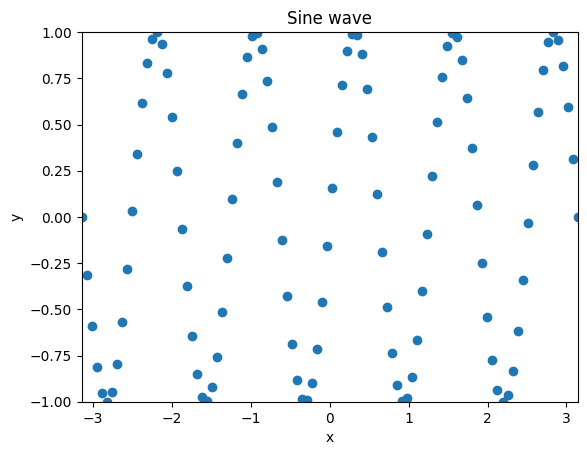

In [ ]:
fig, axis = plt.subplots()
animated_plot, = axis.plot([], [], 'o')

x = np.linspace(-np.pi, np.pi, 100)
b = np.linspace(0.1, 5, 100)
def y(x, b):
  return np.sin(b*x)

axis.set_xlim(-np.pi, np.pi)
axis.set_ylim(-1, 1)
axis.set_title('Sine wave')
axis.set_xlabel('x')
axis.set_ylabel('y')

def update_data(frame):
  animated_plot.set_data(x, y(x, b[frame]))
  return animated_plot,

animation = FuncAnimation(
    fig=fig,
    func=update_data,
    frames=len(x),
    interval=25
)


animation.save('sin.gif')
plt.show()

AttributeError: 'QuadContourSet' object has no attribute 'set_data'

Error in callback <function _draw_all_if_interactive at 0x7a9c3a8753f0> (for post_execute):


ValueError: list.remove(x): x not in list

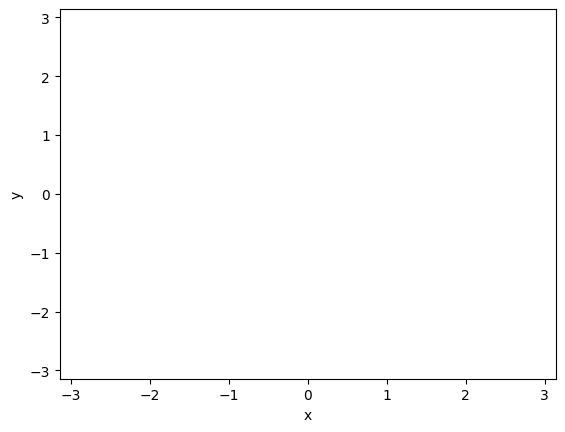

In [ ]:
t_total = 100
x = np.linspace(-np.pi, np.pi, 100)
y = np.linspace(-np.pi, np.pi, 100)
b = np.linspace(0.1, 5, 100)
X, Y = np.meshgrid(x, y)

def z(x, y, b):
  return np.sin(b*x)*np.sin(b*y)

def some_data(i):
  return z(X, Y, b[i])*(i/t_total)

fig = plt.figure()
axis = plt.axes(xlim=(-np.pi, np.pi), ylim=(-np.pi, np.pi), xlabel='x', ylabel='y')

animated_plot = axis.contourf(X, Y, some_data(0), cmap='viridis')

# Animating part
def update_data(frame):
  global animated_plot
  z = some_data(frame)

  for c in animated_plot.collections:
    c.remove() # removes the contours, leaves the rest

  animated_plot.set_data(X, Y, y(X, Y, b[frame]))
  plt.title('t = %i:  %.2f' % (frame,z[5,5]))
  return animated_plot,

animation = FuncAnimation(
    fig=fig,
    func=update_data,
    frames=t_total,
    interval=25
)


animation.save('sin 2d.gif')
plt.show()

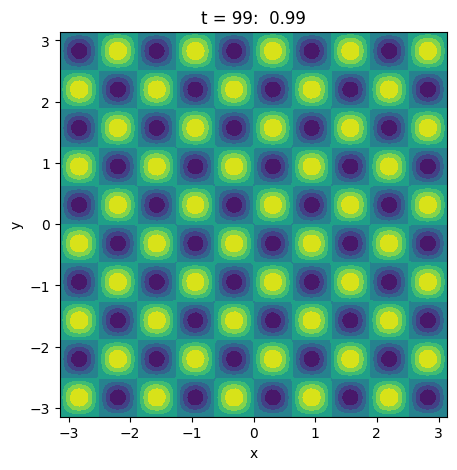

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

t_total = 100
x = np.linspace(-np.pi, np.pi, 100)
y = np.linspace(-np.pi, np.pi, 100)
b = np.linspace(0.1, 5, 100)
X, Y = np.meshgrid(x, y)

def z(x, y, b):
  return np.sin(b*x)*np.sin(b*y)

def some_data(i):
  return z(X, Y, b[i])*(i/t_total)

fig = plt.figure(figsize=(5,5))
axis = plt.axes(xlim=(-np.pi, np.pi), ylim=(-np.pi, np.pi), xlabel='x', ylabel='y')

# Initialize with the first frame's data instead of empty lists
animated_plot = axis.contourf(X, Y, some_data(0), cmap='viridis')

# Animating part
def update_data(frame):
  global animated_plot
  z = some_data(frame)

  # Clear the previous contour plot
  for c in animated_plot.collections:
    c.remove()

  # Create a new contour plot for the current frame
  animated_plot = axis.contourf(X, Y, some_data(frame), cmap='viridis')
  plt.title('t = %i:  %.2f' % (frame,z[5,5]))
  return animated_plot.collections, # Return the new contour collections

animation = FuncAnimation(
    fig=fig,
    func=update_data,
    frames=t_total,
    interval=50
)


animation.save('sin 2d.gif')
plt.show()

Code from [Stack Overflow](https://stackoverflow.com/questions/16915966/using-matplotlib-animate-to-animate-a-contour-plot-in-python)

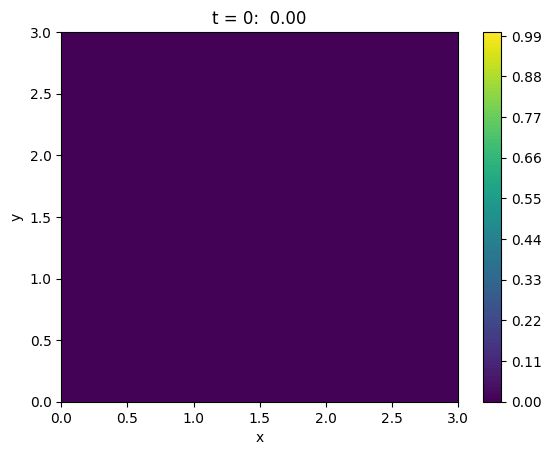

In [ ]:
#plt.rcParams['animation.ffmpeg_path'] = r"C:\some_path\ffmpeg.exe"   # if necessary

# Generate data for plotting
Lx = Ly = 3
Nx = Ny = 11
Nt = 100
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
x,y = np.meshgrid(x,y)
z0 = np.exp(-(x-Lx/2)**2-(y-Ly/2)**2)   # 2 dimensional Gaussian

def some_data(i):   # function returns a 2D data array
    return z0 * (i/Nt)

fig = plt.figure()
ax = plt.axes(xlim=(0, Lx), ylim=(0, Ly), xlabel='x', ylabel='y')

cvals = np.linspace(0,1,Nt+1)      # set contour values
cont = plt.contourf(x, y, some_data(0), cvals)    # first image on screen
plt.colorbar()

# animation function
def animate(i):
    global cont
    z = some_data(i)
    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    cont = plt.contourf(x, y, z, cvals)
    plt.title('t = %i:  %.2f' % (i,z[5,5]))
    return cont

anim = FuncAnimation(fig, animate, frames=Nt, interval=50)
anim.save('quadratic.gif')

## Trying the Philippine map

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Initializing the map
filepath = r'/content/drive/MyDrive/Philippines shapefile/gadm41_PHL_1.shp'
PHL = gpd.read_file(filepath)

# Mesh points
mesh_points = []
for x_point in range(116, 127):
  for y_point in range(4, 22):
    mesh_points.append([x_point, y_point])

dx_theo = 0.25
y_values = np.arange(4, 22, dx_theo)
x_values = np.arange(116, 127, dx_theo)
x_mesh, y_mesh = np.meshgrid(x_values, y_values)

# Converting the mesh of points into a geodataframe
xy_points = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T
geo_points = gpd.GeoDataFrame(xy_points, geometry=gpd.points_from_xy(xy_points[:, 0], xy_points[:, 1]))
geo_points.crs = PHL.crs # making the coordinate system of the two the same
geo_points.columns = ['coord.lon', 'coord.lat', 'geometry']

# Making the points have a buffer
square_points = geo_points.to_crs(crs=PHL.crs).buffer(dx_theo/2, cap_style=3) # dx_theo/2 is the size of buffer, cap_style=3 makes it square
square_points.reset_index(drop=True, inplace=True)

<ipython-input-5-84af9e60a049>:23: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  square_points = geo_points.to_crs(crs=PHL.crs).buffer(dx_theo/2, cap_style=3) # dx_theo/2 is the size of buffer, cap_style=3 makes it square


In [6]:
geo_points

,coord.lon,coord.lat,geometry
0,116.00,4.00,POINT (116.00000 4.00000)
1,116.25,4.00,POINT (116.25000 4.00000)
2,116.50,4.00,POINT (116.50000 4.00000)
3,116.75,4.00,POINT (116.75000 4.00000)
4,117.00,4.00,POINT (117.00000 4.00000)
...,...,...,...
3163,125.75,21.75,POINT (125.75000 21.75000)
3164,126.00,21.75,POINT (126.00000 21.75000)
3165,126.25,21.75,POINT (126.25000 21.75000)
3166,126.50,21.75,POINT (126.50000 21.75000)


In [7]:
odette_data = get_weather_data(geo_points, '2021-12-16', '2021-12-18')

Streaming output truncated to the last 5000 lines.
Timezone None None
Timezone difference to GMT+0 0 s
Iteration: 2169
Coordinates 16.2741641998291°N 119.23077392578125°E
Elevation 0.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Iteration: 2170
Coordinates 16.2741641998291°N 119.4871826171875°E
Elevation 0.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Iteration: 2171
Coordinates 16.2741641998291°N 119.82906341552734°E
Elevation 0.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Iteration: 2172
Coordinates 16.2741641998291°N 120.0°E
Elevation 20.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Iteration: 2173
Coordinates 16.2741641998291°N 120.25641632080078°E
Elevation 0.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Iteration: 2174
Coordinates 16.2741641998291°N 120.42735290527344°E
Elevation 164.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Iteration: 2175
Coordinates 16.2741641998291°N 120.76923370361328°E


In [8]:
odate_data = []
for data in odette_data:
  data_ = data.copy()
  data_['date'] = pd.to_datetime(data['date']).dt.tz_localize(None)
  data_ = data_.set_index('date')
  odate_data.append(data_)

Let's save this in a folder so we can get it later.

Let's resample the data so we can have arrays of numbers instead of dataframes.

In [9]:
odate_arr = np.array(odate_data)
rain_min, rain_max = np.min(odate_arr), np.max(odate_arr)
rain_range = int(np.round(rain_max - rain_min))

In [10]:
colorlist = plt.cm.Blues(np.linspace(0, 1, rain_range))
rain_dict = {i: cm.rgb2hex(colorlist[i]) for i in range(rain_range)}

In [11]:
color_list = []
for i in range(rain_range):
  if i > 30:
    color_list.append(colorlist[-1])
  else:
    color_list.append(colorlist[i])

rain_dict = {i: cm.rgb2hex(color_list[i]) for i in range(rain_range)}

Let's try to visualize the rainfall at Dec 16, 2021 12 AM.

In [12]:
# Getting data of the first df
odate_data[0].iloc[0].values[0]
# odate_data[0] = first df
# .iloc[0] = first date in the df
# .values[0] = getting the element of the list

0.0

In [13]:
date1_list = [np.round(odate_data[i].iloc[0].values[0]) for i in range(len(odate_data))]
date1_color = list(map(rain_dict.get, date1_list))

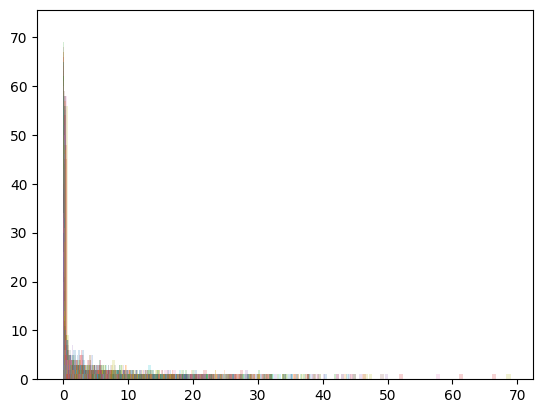

In [ ]:
for i in range(len(odate_data)):
  plt.hist(odate_arr[i], alpha=0.2, bins=100)

Since we just want to see the rainfall, let's make a function that just passes the colors for each day.

In [ ]:
def rainfall_plot(frame):
  # Halving version
  # Run everything until geo_points to make this function work
  # Initialization

  # Rain statistics
  odate_arr = np.array(odate_data)
  rain_min, rain_max = np.min(odate_arr), np.max(odate_arr)
  rain_range = int(np.round(rain_max - rain_min))
  actual_range = np.arange(0, 30).shape[0]

  # Blues
  bluelist = plt.cm.Blues(np.linspace(0, 1, actual_range+1))
  color_list = []
  for i in range(rain_range + 1):
    if i < 10:
      color_list.append(bluelist[int(i/2)])
    elif i >= 10 and i <= 30:
      color_list.append(bluelist[int(i/2)])
    else:
      color_list.append('#333333')
    #else:
     # color_list.append(bluelist[i - actual_range])

  rain_dict = {i: cm.rgb2hex(color_list[i]) for i in range(rain_range + 1)}

  # Rainfall for each date
  rain_date = [int(np.round(odate_data[i].iloc[frame].values[0])) for i in range(len(odate_data))]
  # rain_color = [rain_dict.get(rd, cm.rgb2hex(color_list[-1])) for rd in rain_date]
  rain_color = list(map(rain_dict.get, rain_date))

  # Axes
  ax.set_xlim(116, 127)
  ax.set_ylim(4, 22)
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')

  # Title
  dates = list(odate_data[0].index)
  ax.set_title(f'Rainfall at {dates[frame]}')

  # Plotting
  im_points = square_points.plot(ax=ax, color=rain_color)
  PHL.plot(ax=ax, color='none', edgecolor='#333333', linewidth=1)
  ax.grid(linestyle='--', color='lightgray')

  return im_points

In [37]:
def rainfall_plot(frame):
  # Run everything until geo_points to make this function work
  # Initialization

  # Rain statistics
  odate_arr = np.array(odate_data)
  rain_min, rain_max = np.min(odate_arr), np.max(odate_arr)
  rain_range = int(np.round(rain_max - rain_min))
  actual_range = np.arange(0, 30).shape[0]

  # Blues
  bluelist = plt.cm.Blues(np.linspace(0, 1, actual_range+1))
  color_list = []
  for i in range(rain_range + 1):
    if i <= 30:
      color_list.append(bluelist[i])
    else:
      color_list.append('#333333')
    #else:
     # color_list.append(bluelist[i - actual_range])

  rain_dict = {i: cm.rgb2hex(color_list[i]) for i in range(rain_range + 1)}

  # Rainfall for each date
  rain_date = [int(np.round(odate_data[i].iloc[frame].values[0])) for i in range(len(odate_data))]
  # rain_color = [rain_dict.get(rd, cm.rgb2hex(color_list[-1])) for rd in rain_date]
  rain_color = list(map(rain_dict.get, rain_date))

  # Axes
  ax.set_xlim(116, 127)
  ax.set_ylim(4, 22)
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')

  # Title
  dates = list(odate_data[0].index)
  ax.set_title(f'Rainfall at {dates[frame]}')

  # Plotting
  im_points = square_points.plot(ax=ax, color=rain_color)
  PHL.plot(ax=ax, color='none', edgecolor='#333333', linewidth=1)
  ax.grid(linestyle='--', color='lightgray')

  return im_points

In [ ]:
len(np.linspace(0, 1, np.arange(0, 30).shape[0]+1))

31

ValueError: left cannot be >= right

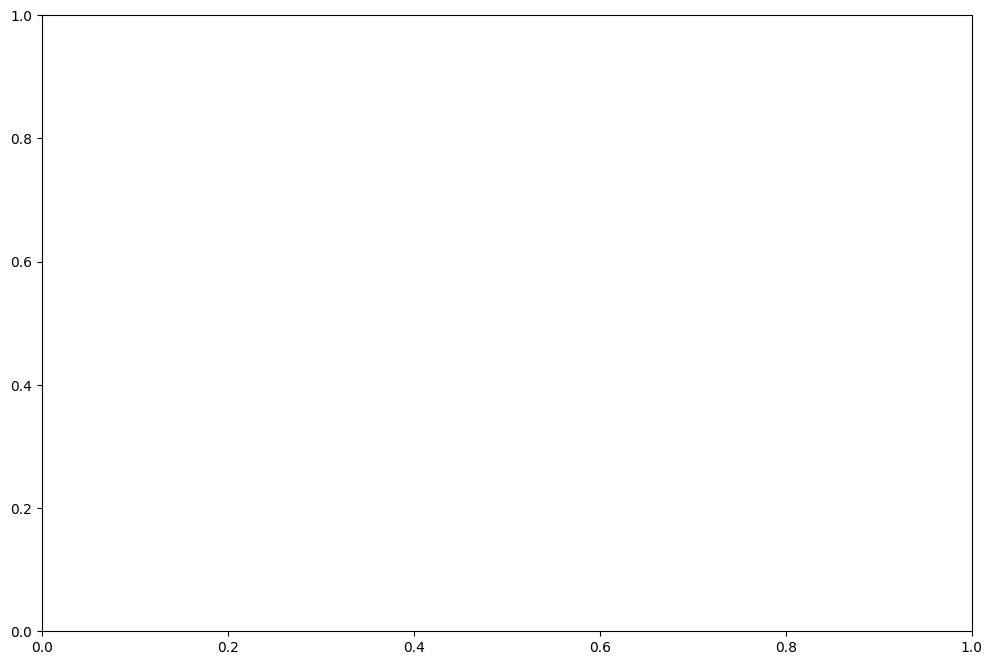

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
rainfall_plot(11)
plt.savefig('odette 11.png')

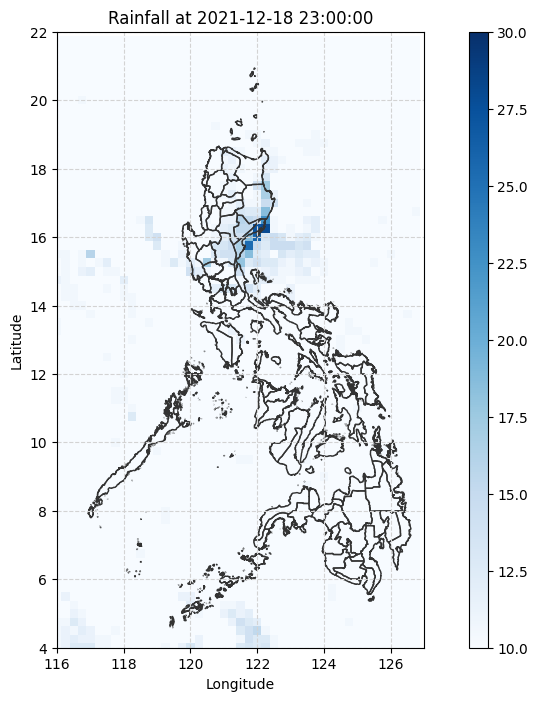

In [ ]:
t_total = len(odate_data[0])

fig, ax = plt.subplots()
# fig.subplots_adjust(left=3, bottom=3, right=0, top=0, wspace=None, hspace=None)
fig.set_size_inches(12, 8)

# Initialize with the first frame's data instead of empty lists
animated_plot = rainfall_plot(0)

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.40)
color_mappable = ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=10, vmax=30))
fig.colorbar(color_mappable, cax)

# Animating part
def update_data(frame):
  global animated_plot

  # Clear the previous contour plot
  for c in animated_plot.collections:
    c.remove()

  # Create a new contour plot for the current frame
  animated_plot = rainfall_plot(frame)
  # plt.title('t = %i:  %.2f' % (frame,z[5,5]))
  return animated_plot.collections, # Return the new contour collections

animation = FuncAnimation(
    fig=fig,
    func=update_data,
    frames=t_total,
    interval=200
)


animation.save('odate rainfall.gif', savefig_kwargs={ "bbox_inches": "tight" })
plt.show()

Text(0, 0.5, 'Rainfall (mm)')

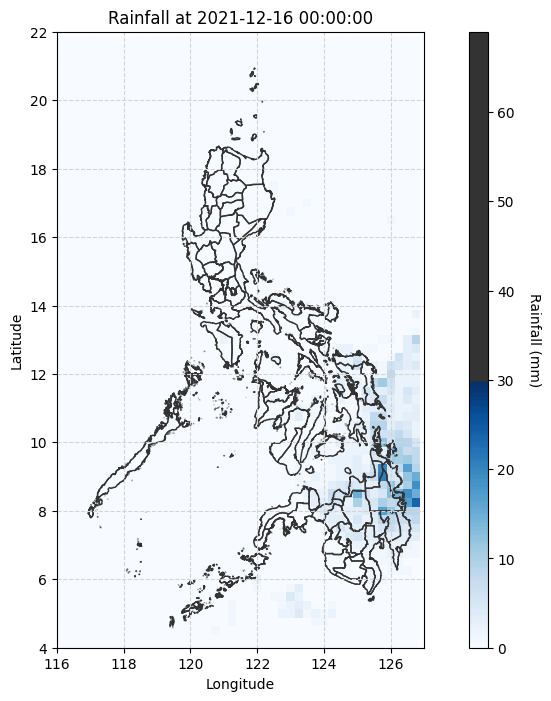

In [55]:
t_total = len(odate_data[0])

fig, ax = plt.subplots()
# fig.subplots_adjust(left=3, bottom=3, right=0, top=0, wspace=None, hspace=None)
fig.set_size_inches(12, 8)

# Initialize with the first frame's data instead of empty lists
animated_plot = rainfall_plot(0)

# Colorbar
## Colors
blues = mpl.colormaps['Blues'].resampled(88)
bottom = blues(np.linspace(0, 1, 128))
top = np.array([[0.2, 0.2, 0.2, 1.] for i in range(168)])
new_colorlist = np.vstack((bottom, top))
new_cmap = mpl.colors.LinearSegmentedColormap.from_list('new_cmap', new_colorlist)

## Bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.40)
color_mappable = ScalarMappable(cmap=new_cmap, norm=plt.Normalize(vmin=0, vmax=69))
cbar = fig.colorbar(color_mappable, cax)
cbar.ax.set_ylabel('Rainfall (mm)', rotation=270, labelpad=19)

Animating with the new colorbar

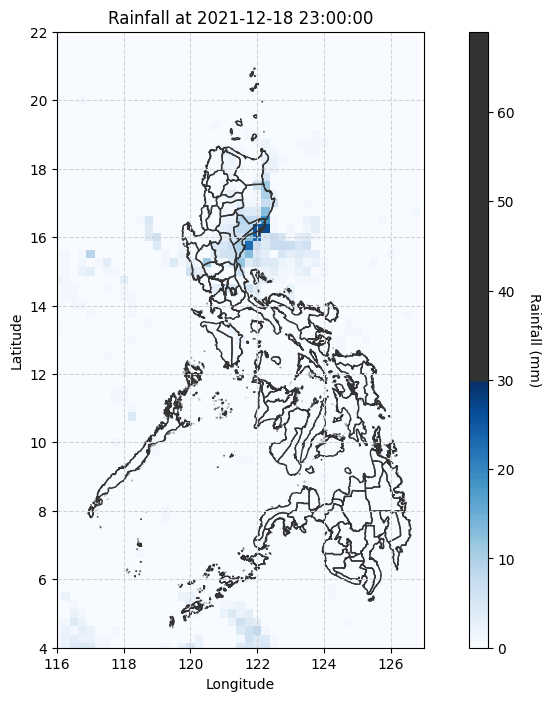

In [56]:
t_total = len(odate_data[0])

fig, ax = plt.subplots()
# fig.subplots_adjust(left=3, bottom=3, right=0, top=0, wspace=None, hspace=None)
fig.set_size_inches(12, 8)

# Initialize with the first frame's data instead of empty lists
animated_plot = rainfall_plot(0)

# Colorbar
## Colors
blues = mpl.colormaps['Blues'].resampled(88)
bottom = blues(np.linspace(0, 1, 128))
top = np.array([[0.2, 0.2, 0.2, 1.] for i in range(168)])
new_colorlist = np.vstack((bottom, top))
new_cmap = mpl.colors.LinearSegmentedColormap.from_list('new_cmap', new_colorlist)

## Bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.40)
color_mappable = ScalarMappable(cmap=new_cmap, norm=plt.Normalize(vmin=0, vmax=69))
cbar = fig.colorbar(color_mappable, cax)
cbar.ax.set_ylabel('Rainfall (mm)', rotation=270, labelpad=19)

# Animating part
def update_data(frame):
  global animated_plot

  # Clear the previous contour plot
  for c in animated_plot.collections:
    c.remove()

  # Create a new contour plot for the current frame
  animated_plot = rainfall_plot(frame)
  # plt.title('t = %i:  %.2f' % (frame,z[5,5]))
  return animated_plot.collections, # Return the new contour collections

animation = FuncAnimation(
    fig=fig,
    func=update_data,
    frames=t_total,
    interval=200
)


animation.save('odate rainfall.gif', savefig_kwargs={ "bbox_inches": "tight" })
plt.show()